In [1]:
import os, sys

PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

print("PROJECT_ROOT:", PROJECT_ROOT)

%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.data_loading_cross import load_sp500_adj_close
from src.signals_cross import (
    make_cross_sectional_signals,
    build_cross_sectional_matrix,
    CROSS_FEATURES,
)




PROJECT_ROOT: c:\Users\gehra\Documents\GitHub\Quant_coding


In [2]:
# Load SP500 panel, as long as we can reasonably go
prices = load_sp500_adj_close(start="2000-01-01")
prices = load_sp500_adj_close(start="2000-01-01", force_download=True)

prices.info()
prices.head()
print("Price panel shape:", prices.shape)
print("Date range:", prices.index.min(), "->", prices.index.max())
print("Number of tickers:", len(prices.columns))


Universe size from CSV: 503
  -> Batch close shape: (6528, 50)
  -> Batch close shape: (6528, 50)
  -> Batch close shape: (6528, 50)
  -> Batch close shape: (6528, 50)
  -> Batch close shape: (6528, 50)
  -> Batch close shape: (6528, 50)
  -> Batch close shape: (6528, 50)
  -> Batch close shape: (6528, 50)
  -> Batch close shape: (6528, 50)
  -> Batch close shape: (6528, 50)
  -> Batch close shape: (6528, 3)
Final price panel shape: (6528, 503)
Saved S&P 500 adj close to C:\Users\gehra\Documents\GitHub\Quant_coding\data\sp500_adj_close.parquet
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6528 entries, 2000-01-03 to 2025-12-15
Columns: 503 entries, NVDA to NWS
dtypes: float64(503)
memory usage: 25.1 MB
Price panel shape: (6528, 503)
Date range: 2000-01-03 00:00:00 -> 2025-12-15 00:00:00
Number of tickers: 503


In [ ]:
lookahead = 21  # ~1 month forward return

signals_df = make_cross_sectional_signals(prices, lookahead=lookahead)

signals_df.head()
print("Signals shape:", signals_df.shape)
print("Columns:", signals_df.columns.tolist())

dates_all = signals_df.index.get_level_values("date")
tickers_all = signals_df.index.get_level_values("ticker")

print("Signals date range:", dates_all.min(), "->", dates_all.max())
print("Unique tickers in signals:", len(np.unique(tickers_all)))




c:\Users\gehra\Documents\GitHub\Quant_coding\src\signals_cross.py:47: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret_1 = prices.pct_change(1)
c:\Users\gehra\Documents\GitHub\Quant_coding\src\signals_cross.py:48: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret_5 = prices.pct_change(5)
c:\Users\gehra\Documents\GitHub\Quant_coding\src\signals_cross.py:49: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill N

Signals shape: (2762259, 12)
Columns: ['ret_1', 'ret_5', 'ret_10', 'ret_21', 'vol_10', 'vol_20', 'vol_60', 'ma20_rel', 'ma50_rel', 'ma200_rel', 'target_fwd_21', 'dow']
Signals date range: 2000-10-16 00:00:00 -> 2025-11-13 00:00:00
Unique tickers in signals: 500


X shape: (2762259, 11)
y shape: (2762259,)
Feature names: ['ret_1', 'ret_5', 'ret_10', 'ret_21', 'vol_10', 'vol_20', 'vol_60', 'ma20_rel', 'ma50_rel', 'ma200_rel', 'dow']
Min/max date: 2000-10-16 00:00:00 -> 2025-11-13 00:00:00
Num unique tickers: 500


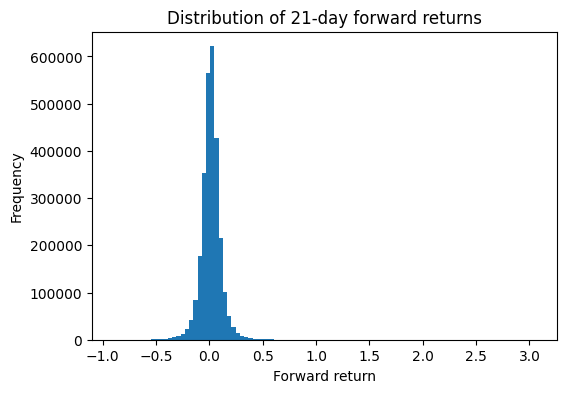

In [4]:
X, y, dates, tickers = build_cross_sectional_matrix(signals_df)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Feature names:", CROSS_FEATURES)
print("Min/max date:", dates.min(), "->", dates.max())
print("Num unique tickers:", np.unique(tickers).size)

# Quick sanity checks on target distribution
plt.figure(figsize=(6, 4))
plt.hist(y, bins=100)
plt.title(f"Distribution of {lookahead}-day forward returns")
plt.xlabel("Forward return")
plt.ylabel("Frequency")
plt.show()


In [5]:
# --- Date-based split: train / val / test ---

unique_dates = np.array(sorted(dates.unique()))
n_dates = len(unique_dates)
print("Number of trading days in panel:", n_dates)

# 60% train, 20% val, 20% test by time
train_end = unique_dates[int(n_dates * 0.6)]
val_end   = unique_dates[int(n_dates * 0.8)]

print("Train end date:", train_end)
print("Val   end date:", val_end)

mask_train = dates <= train_end
mask_val   = (dates > train_end) & (dates <= val_end)
mask_test  = dates > val_end

X_train, y_train = X[mask_train], y[mask_train]
X_val,   y_val   = X[mask_val],   y[mask_val]
X_test,  y_test  = X[mask_test],  y[mask_test]

dates_train = dates[mask_train]
dates_val   = dates[mask_val]
dates_test  = dates[mask_test]
tickers_test = tickers[mask_test]

print("Train samples:", len(y_train))
print("Val   samples:", len(y_val))
print("Test  samples:", len(y_test))


Number of trading days in panel: 6308
Train end date: 2015-11-02 00:00:00
Val   end date: 2020-11-05 00:00:00
Train samples: 1541169
Val   samples: 597651
Test  samples: 623439


In [6]:
# --- Baseline cross-sectional momentum on TEST period ---

# We'll use signals_df again but only for dates > val_end
idx_dates = signals_df.index.get_level_values("date")
signals_test = signals_df.loc[idx_dates > val_end].copy()

signals_test.head()


ret_1     ret_5    ret_10    ret_21    vol_10    vol_20  \
date       ticker                                                               
2020-11-06 NVDA    0.028390  0.161800  0.071504  0.052263  0.037831  0.028893   
           AAPL   -0.001136  0.092181  0.033508  0.034137  0.033096  0.028937   
           MSFT    0.001926  0.104954  0.034639  0.062399  0.028543  0.021612   
           AMZN   -0.003200  0.090648  0.033382  0.037868  0.033388  0.027150   
           GOOGL  -0.001572  0.088868  0.077619  0.186257  0.032907  0.025349   

                     vol_60  ma20_rel  ma50_rel  ma200_rel  target_fwd_21  dow  
date       ticker                                                               
2020-11-06 NVDA    0.031773 -0.070149 -0.091914  -0.343133      -0.082960    4  
           AAPL    0.028638 -0.021536 -0.023565  -0.231182       0.047940    4  
           MSFT    0.021680 -0.042421 -0.052821  -0.148121      -0.031935    4  
           AMZN    0.025319 -0.023330 -0.032249  -0.198448      -0.040491    4  
           GOOGL   0.021803 -0.087077 -0.119515  -0.187283       0.029323    4

In [10]:
def daily_momentum_cs(group: pd.DataFrame, q: float = 0.1, horizon: int = 21) -> pd.Series:
    """
    Cross-sectional momentum for a single date.

    group: rows for one date, many tickers.
    q: top/bottom quantile, e.g. 0.1 for deciles.
    horizon: forward horizon used for the target (e.g. 21 days).
    """
    n = len(group)
    if n < 10:
        return pd.Series({"eqw": 0.0, "long": 0.0, "long_short": 0.0})

    # equal-weight all stocks -> "index" (21-day return)
    eqw_ret_21 = group["target_fwd_21"].mean()

    # sort by past 21d return
    g_sorted = group.sort_values("ret_21")
    k = max(1, int(n * q))

    bottom = g_sorted.iloc[:k]
    top    = g_sorted.iloc[-k:]

    long_ret_21  = top["target_fwd_21"].mean()
    short_ret_21 = bottom["target_fwd_21"].mean()

    # convert 21-day returns to daily-equivalent returns
    def to_daily(R):
        return (1.0 + R) ** (1.0 / horizon) - 1.0

    eqw_ret_daily   = to_daily(eqw_ret_21)
    long_ret_daily  = to_daily(long_ret_21)
    short_ret_daily = to_daily(short_ret_21)
    long_short_daily = long_ret_daily - short_ret_daily

    return pd.Series(
        {
            "eqw": eqw_ret_daily,
            "long": long_ret_daily,
            "long_short": long_short_daily,
        }
    )


In [11]:
daily_cs_rets = signals_test.groupby("date").apply(daily_momentum_cs, q=0.1)
daily_cs_rets.head()

eqw_returns        = daily_cs_rets["eqw"]
mom_long_returns   = daily_cs_rets["long"]
mom_ls_returns     = daily_cs_rets["long_short"]


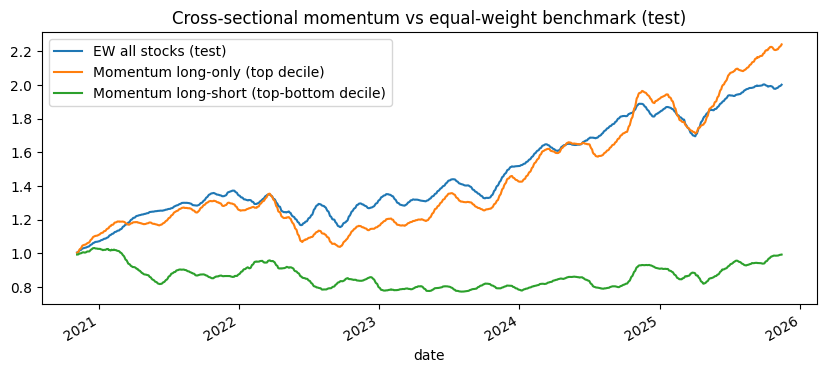

{'eqw_cagr': 0.147530008259267,
 'eqw_vol': np.float64(0.03198550174158072),
 'eqw_sharpe': np.float64(4.666246172883297),
 'eqw_max_dd': -0.15781487477646128,
 'momL_cagr': 0.17404823891586663,
 'momL_vol': np.float64(0.04009895617600929),
 'momL_sharpe': np.float64(4.384943490736639),
 'momL_max_dd': -0.23322830378375214,
 'momLS_cagr': -3.2422053756864244e-05,
 'momLS_vol': np.float64(0.03919055459749544),
 'momLS_sharpe': np.float64(-0.01930360901540034),
 'momLS_max_dd': -0.25123525897092125}

In [12]:
from src.backtest import (
    equity_curve_from_returns,
    cagr,
    annualized_vol,
    sharpe_ratio,
    max_drawdown,
)

equity_eqw     = equity_curve_from_returns(eqw_returns)
equity_mom_L   = equity_curve_from_returns(mom_long_returns)
equity_mom_LS  = equity_curve_from_returns(mom_ls_returns)

plt.figure(figsize=(10, 4))
equity_eqw.plot(label="EW all stocks (test)")
equity_mom_L.plot(label="Momentum long-only (top decile)")
equity_mom_LS.plot(label="Momentum long-short (top-bottom decile)")
plt.legend()
plt.title("Cross-sectional momentum vs equal-weight benchmark (test)")
plt.show()

metrics_cs = {
    "eqw_cagr":     cagr(equity_eqw),
    "eqw_vol":      annualized_vol(eqw_returns),
    "eqw_sharpe":   sharpe_ratio(eqw_returns),
    "eqw_max_dd":   max_drawdown(equity_eqw),

    "momL_cagr":    cagr(equity_mom_L),
    "momL_vol":     annualized_vol(mom_long_returns),
    "momL_sharpe":  sharpe_ratio(mom_long_returns),
    "momL_max_dd":  max_drawdown(equity_mom_L),

    "momLS_cagr":   cagr(equity_mom_LS),
    "momLS_vol":    annualized_vol(mom_ls_returns),
    "momLS_sharpe": sharpe_ratio(mom_ls_returns),
    "momLS_max_dd": max_drawdown(equity_mom_LS),
}
metrics_cs
